In [21]:
import sys
import torch
import json
import numpy                as np
import datetime             as dt
from time                   import time
import matplotlib.pyplot    as plt
# import matplotlib           as mpl
from matplotlib          import rcParams
rcParams.update({'figure.dpi': 200})
# mpl.rcParams.update({'font.size': 10})
# plt.rcParams['figure.dpi'] = 200


## import own functions
sys.path.insert(1, '/STER/silkem/MACE/src/mace')
import dataset      as ds
import train        as tr
import neuralODE    as nODE
import utils        as utils
import plotting     as pl
import loss

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
start = time()
name = dt.datetime.now()
path = '/STER/silkem/MACE/models/'+str(name)


## ================================================== INPUT ========
## ADJUST THESE PARAMETERS FOR DIFFERENT MODELS

lr = 1.e-3
tot_epochs = 10
nb_epochs  = 5
z_dim = 10
dt_fract = 0.2
# dirname = 'C-short-dtime'
# dirname = 'new'
dirname = 'easy-mace2'

## ================================================== INPUT ========



## Set up PyTorch 
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")
batch_size = 1 ## if not 1, dan kan er geen tensor van gemaakt worden

kwargs = {'num_workers': 1, 'pin_memory': True} 



## Load train & test data sets 
train, test, data_loader, test_loader = ds.get_data(dirname = dirname,dt_fract=dt_fract, batch_size=batch_size, kwargs=kwargs)
## Make model
model = nODE.Solver(p_dim=4,z_dim = z_dim, n_dim=466, DEVICE = DEVICE)


## --------------------------------------- TRAINING ----------------

## ------------- PART 1: unnormalised losses 
norm = {'mse' : 1,
        'rel' : 1,
        'evo' : 1}

fract = {'mse' : 1, 
         'rel' : 1,
         'evo' : 1}


## Make loss objects
trainloss = loss.Loss(norm, fract)
testloss  = loss.Loss(norm, fract)

tic = time()
trainloss, testloss = tr.train(model, lr, data_loader, test_loader, None, end_epochs = 2, DEVICE= DEVICE, trainloss=trainloss, testloss=testloss, plot = False, log = True, show = True)
toc = time()
train_time1 = toc-tic

# ## ------------- PART 2: normalised losses, but reinitialise model
# model = nODE.Solver(p_dim=4,z_dim = z_dim, n_dim=466, DEVICE = DEVICE)

norm = {'mse' : 1,
        'rel' : 1,
        'evo' : 1}

trainloss.change_norm({'mse' :np.mean(trainloss.get_loss('mse')),
                       'rel' :np.mean(trainloss.get_loss('rel')),
                       'evo' :np.mean(trainloss.get_loss('evo'))})  
testloss.change_norm({'mse' :np.mean(testloss.get_loss('mse')),
                        'rel' :np.mean(testloss.get_loss('rel')),
                        'evo' :np.mean(testloss.get_loss('evo'))})

tic = time()
trainloss, testloss = tr.train(model, lr, data_loader, test_loader,None, end_epochs = nb_epochs, DEVICE= DEVICE, trainloss=trainloss, testloss=testloss, start_epochs=2, plot = False, log = True, show = True)
toc = time()
train_time2 = toc-tic

# ## ------------- PART 3: increase losses with factor & train further
# fract = {'mse' : 100, 
#          'rel' : 100,
#          'evo' : 100}
# trainloss.change_fract(fract)
# testloss.change_fract(fract)

# tic = time()
# trainloss, testloss = tr.train(model, lr, data_loader, test_loader, None, end_epochs = tot_epochs, DEVICE= DEVICE, trainloss=trainloss, testloss=testloss, start_epochs=50, plot = False, log = True, show = False)
# toc = time()
# train_time3 = toc-tic



Dataset:
------------------------------
total # of samples: 100
# training samples: 70
#  testing samples: 30
             ratio: 0.3
Model:         
learning rate: 0.001

>>> Training model...

1.3224616800405908e+18


	batch 30 / 30
Epoch 3 complete! 	Average loss train:  1.3224616800405908e+18 	Average loss test:  6.367457679685714e+16
5.8656367625191896e+16


	batch 30 / 30
Epoch 3 complete! 	Average loss train:  5.8656367625191896e+16 	Average loss test:  5.270630572899697e+16
 	DONE!
Model:         
learning rate: 0.001

>>> Training model...

0.17096451198948281


	batch 30 / 30
Epoch 6 complete! 	Average loss train:  0.17096451198948281 	Average loss test:  1.5443452892204126
0.12117296193859407


	batch 30 / 30
Epoch 6 complete! 	Average loss train:  0.12117296193859407 	Average loss test:  1.2097968950867652
0.08388548040363406


	batch 30 / 30
Epoch 6 complete! 	Average loss train:  0.08388548040363406 	Average loss test:  0.5547049131244421
 	DONE!


In [88]:
trainpath = 'train'
testpath  = 'test'

trainloss.save(trainpath)
testloss.save(testpath)

In [86]:
model.get_status('train')

[0.0, 0.0, 0.0, 0.0, 0.0]

In [75]:
trainloss.get_tot_loss()

array([1.32246168e+18, 5.86563676e+16, 1.70964512e-01, 1.21172962e-01,
       8.38854804e-02])

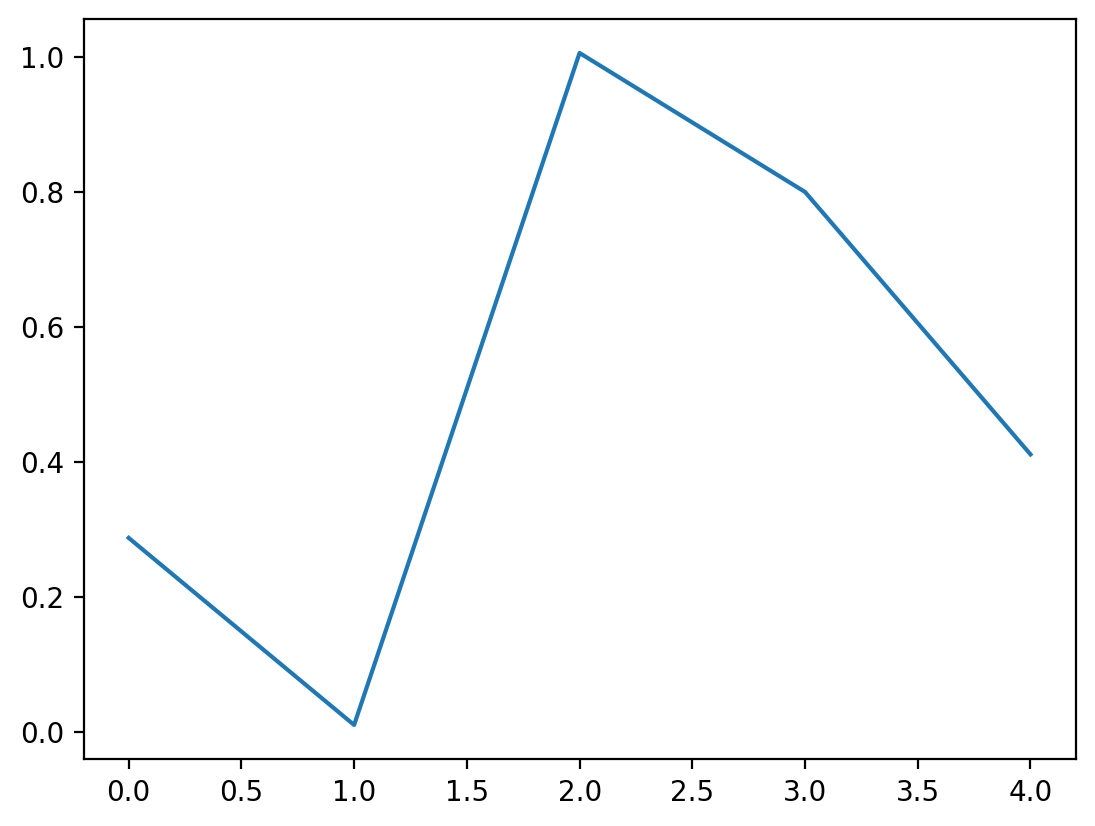

In [83]:
mse_idv = trainloss.get_idv_loss('mse')
plt.plot(np.array(mse_idv).T[5])
plt.show()
